In [4]:
from google.colab import drive
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class SimpleRnn(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(SimpleRnn, self).__init__()

    self.W_xh = nn.Parameter(torch.randn(input_size, hidden_size).to(device))
    self.W_hh = nn.Parameter(torch.randn(hidden_size, hidden_size).to(device))
    self.b_h = nn.Parameter(torch.zeros(hidden_size).to(device))

    self.W_yh = nn.Parameter(torch.randn(hidden_size, output_size).to(device))
    self.b_y = nn.Parameter(torch.zeros(output_size).to(device))

  def forward(self, x):
    batch_size, seq_length, _ = x.size()

    h = torch.zeros(batch_size, self.W_hh.size(0), device=device)

    for i in range(seq_length):
      xt = x[:, i, :]
      h = torch.tanh(torch.matmul(xt, self.W_xh) + torch.matmul(h, self.W_hh) + self.b_h)

    y = torch.matmul(h, self.W_yh) + self.b_y
    return y

In [6]:
# creating model
g = torch.Generator(device=device).manual_seed(2)

C_dimensions = 30

class Model(nn.Module):
  def __init__(self, rnn_hidden_size=700):
    super(Model, self).__init__()
    self.C = torch.randn(len(tokens), C_dimensions, generator=g, device=device)

    self.rnn = SimpleRnn(input_size=C_dimensions, hidden_size=rnn_hidden_size, output_size=rnn_hidden_size)

    self.L1_size = 1500
    self.W1 = torch.randn(rnn_hidden_size, self.L1_size, generator=g, device=device)
    self.B1 = torch.randn(self.L1_size, generator=g, device=device)

    self.W2 = torch.randn(self.L1_size, len(tokens), generator=g, device=device)
    self.B2 = torch.randn(len(tokens), generator=g, device=device)

    self.p = [self.C, self.W1, self.B1, self.W2, self.B2]

    for param in self.p:
      param.requires_grad = True

  def forward(self, x):
    emb = self.C[x]

    rnn_output = self.rnn(emb)

    h = torch.tanh(rnn_output @ self.W1 + self.B1)
    logits = h @ self.W2 + self.B2
    return logits

  def forward_train(self, x, y):
    logits = self.forward(x)
    loss = F.cross_entropy(logits, y)
    return loss


# Shecspir Dataset

In [7]:
import requests

url = "https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt"

text_data = requests.get(url)
text_data = text_data.text

In [8]:
# genereting tokens
tokens = []

for letter in text_data:
  if letter not in tokens:
    tokens.append(letter)

tokens.sort()
tokens = ["."] + tokens
stoi = {}
itos = {}
for i in range(len(tokens)):
  itos[i] = tokens[i]
  stoi[tokens[i]] = i
tokens_length = len(stoi)

# transform to tokens
X = []
Y = []

for i in range(len(text_data) - 1):
  X.append(stoi[text_data[i]])
  Y.append(stoi[text_data[i + 1]])

X_tensor = torch.tensor(X)
Y_tensor = torch.tensor(Y)

train_size = int(len(X_tensor) * 0.8)
val_size = int(len(X_tensor) * 0.1)

X_train, Y_train = X_tensor[:train_size], Y_tensor[:train_size]
X_val, Y_val = X_tensor[train_size:train_size + val_size], Y_tensor[train_size:train_size + val_size]
X_test, Y_test = X_tensor[train_size + val_size:], Y_tensor[train_size + val_size:]

In [9]:
model = Model().to(device)

0 0
100 21.430524826049805
200 14.98901081085205
300 14.498205184936523
400 11.530359268188477
500 8.058822631835938
600 8.519899368286133
700 9.20036792755127
800 7.343405246734619
900 7.330499172210693
1000 7.480223655700684
1100 6.04953145980835
1200 5.467019557952881
1300 5.703136920928955
1400 4.96088981628418
1500 6.040004730224609
1600 7.175450325012207
1700 5.039032936096191
1800 5.155941963195801
1900 5.530125141143799


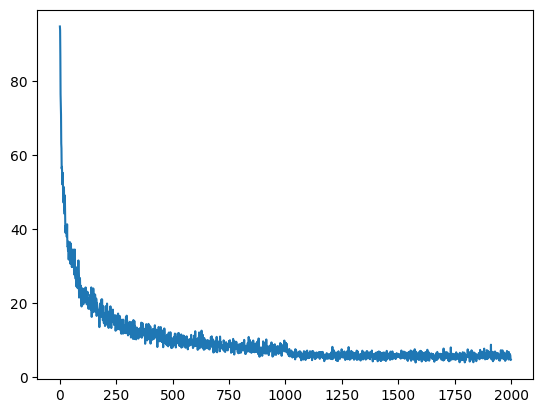

In [10]:
loss_ar = []
loss = torch.tensor(0)

batch_size = 320
context_length = 10

for k in range(2000):
  if k % 100 == 0:
    print(k, loss.item())
  ix = torch.randint(0, X_train.shape[0] - context_length, (batch_size,), device=device)

  X_batch = torch.stack([X_train[i:i+context_length] for i in ix])
  Y_batch = torch.stack([Y_train[i+context_length] for i in ix])

  X_batch = X_batch.to(device)
  Y_batch = Y_batch.to(device)

  # forward pass
  loss = model.forward_train(X_batch, Y_batch)

  # backward pass
  for param in model.p:
    param.grad = None
  loss.backward()
  if k < 1000:
    lr = 0.1
  else:
    lr = 0.01
  for param in model.p:
    param.data += -lr * param.grad

  loss_ar += [loss.item()]
plt.plot(loss_ar)


In [14]:
# test dataset
ix = torch.randint(0, X_test.shape[0] - context_length, (1000,), device=device)

X_batch = torch.stack([X_test[i:i+context_length] for i in ix])
Y_batch = torch.stack([X_test[i+context_length] for i in ix])
X_batch = X_batch.to(device)
Y_batch = Y_batch.to(device)
model.forward_train(X_batch, Y_batch)
loss.item()

4.744330406188965

In [16]:
# validate dataset
ix = torch.randint(0, X_val.shape[0] - context_length, (1000,), device=device)

X_batch = torch.stack([X_val[i:i+context_length] for i in ix])
Y_batch = torch.stack([Y_val[i+context_length] for i in ix])
X_batch = X_batch.to(device)
Y_batch = Y_batch.to(device)
model.forward_train(X_batch, Y_batch)
loss.item()

4.744330406188965

In [63]:
def generate_content(model, start_token, max_length=100, temperature = 1):
  model.eval()

  context = [start_token] * context_length
  generated_tokens = context.copy()

  context_tensor = torch.tensor(context, dtype=torch.long, device=device).unsqueeze(0)

  with torch.no_grad():
    for _ in range(max_length):
      logits = model(context_tensor)
      logits = logits / temperature
      probs = F.softmax(logits, dim=-1)
      next_token = torch.multinomial(probs, 1).item()

      generated_tokens.append(next_token)

      context_tensor = torch.cat([context_tensor[:, 1:], torch.tensor([[next_token]], device=device)], dim=1)

  generated_text = ''.join([itos[idx] for idx in generated_tokens])

  return generated_text

In [64]:
start_token = stoi["w"]

generated_text = generate_content(model, start_token=start_token, max_length=500)

# Print the generated content
print(generated_text)

wwwwwwwwwwtu a hoeed  o o ' e, o r E(D0~Wa l. e  nei nh  a aetf8x`i oe ehses
 Adyaeka usladt,t ha  y ee   ao  ys yorae   nt yl. arnue p  orb<&ob HR. aOMBT  i  i f tnt/,snt  uhls, eciknu l n(geo,tdml  anod
 eise  ALbdei'l PGRSaeek%*fyuhvorno t
 oeca nnehsage yu nat  as hmneinyw es, onU[ ot e oecrcal  hrseo FxPD]    odan e  ottra o   o x[us,TR. T Exuiseko hbuhtf8s ohe. dsogt gtuuh y
 om hn e ol esao tyl eho uad e ohmt   
 ihv htuilyusca  aymntrhns  rete A2OMU uhan ae G
 htuegds  aeetohed hvnt  h e I AL)>q}I
